# Neural Networks for Data Science
## End-of-term homework: KV Cache handling and compression

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jrand
import equinox as eqx
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import optax
from typing import NamedTuple
import time
import json
import os
from preprocess import filter_and_clean_moves, split_input_target, Tokenizer, create_dataset
from layers import attention, MultiHeadAttention, TransformerBlock
from model import DecoderTransformer
from train_evaluate import *
from kv_cache import KVCache, compress_cache

### Instructions

1. The homework has two exercises, only the first one is mandatory to access the oral exam.
2. The second exercise is graded (4 points). Without it, the maximum mark for the oral will be 26.
3. Lode requires *exceptional* solutions and orals (top 5%).
4. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2026).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use external material (including AI tools), reference it *explicitly* in the corresponding cell. Copy-paste *is not allowed*.

> 🔵 *Grammar*: please try to be precise and provide nice-to-read descriptions.

> 🟥 *JAX*: the homework must be done _in JAX_ or high-level JAX libraries (Haiku, Flax, equinox, ...). You cannot use libraries that directly solve the core exercise(s). When in doubt, ask.

> 🟪 *Math*: you can use LaTeX in Markdown if you need to write equations or if you need generic math notation.


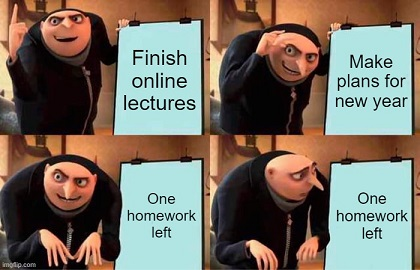

## Warmup: Data loading

For this part, select a dataset that you like, keeping in mind task complexity with respect to the available hardware.

*   You can use any data processing you want (PyTorch data loaders, TensorFlow datasets, Grain, HuggingFace Dataset, ...).
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code. Describe the preprocessing you have applied.*

**TODO**: add description here (1-2 paragraphs).

## Dataset Description

The dataset<sup><a href="#footnote1">[1]</a></sup> contains 1 million chess games played on the online chess platform Lichess<sup><a href="#footnote2">[2]</a></sup> during February 2016.
Each observation represents a single game and it is characterized by:
- The event in which the game was played
- The link to the game
- The usernames of the users playing
- The result of the game
- The list of moves played in the game in Portable Game Notation (PGN): a standard plain text format for recording chess games (formatted as `turn_number`. `white_move` `black_move`)<sup><a href="#footnote3">[3]</a></sup>

The event column contains different types of events, most of them are associated with the event link, making the number of unique events explode to 703. After removing the event-specific URLs, the events collapse to 7 unique types, corresponding to 4 different chess game modalities. After filtering the dataset to retain only classical chess games and dropping all the rows containing NaN values, slightly more than 260000 samples are contained in the final dataset.

As part of the preprocessing pipeline, turn indices were removed, each game was split into a sequence of individual moves, and special [BOS] and [EOS] tokens were added at the beginning and end of each sequence, respectively.

The model is trained to perform autoregressive next-move prediction on sequences of chess moves, where each move is treated as a discrete token. It is important to note that the model does not explicitly encode the board state, game rules, or constraints on legal moves.

<a name="footnote1"></a>
[1] https://www.kaggle.com/datasets/aapohermankoskinen/lichess-1-million-chess-games

<a name="footnote2"></a>
[2] https://lichess.org/it

<a name="footnote3"></a>
[3] https://en.wikipedia.org/wiki/Portable_Game_Notation

In [5]:
print(jax.devices())

[CudaDevice(id=0)]


In [ ]:
df = pd.read_csv('games_cleaned.csv')
df.head()

,Event,Site,White,Black,Result,Moves
0,Rated Blitz tournament https://lichess.org/tou...,https://lichess.org/npDpU5Pm,Wallerdos,chilico,0-1,NaN
1,Rated Blitz tournament https://lichess.org/tou...,https://lichess.org/ivwkDdC3,patatero,hichamsbitri,1-0,1. d4
2,Rated Blitz tournament https://lichess.org/tou...,https://lichess.org/OIR2O8JN,Ayman22,daamien,1-0,1. e4 c6 2. Nf3 d5 3. Nc3 d4 4. Ne2 e5 5. c3 d...
3,Rated Blitz tournament https://lichess.org/tou...,https://lichess.org/OWLzXHxG,shadowtiger,BillDecant5,1-0,1. e4 c5 2. d4 Nc6 3. dxc5 g6 4. Nf3 Bg7 5. Bd...
4,Rated Bullet tournament https://lichess.org/to...,https://lichess.org/1dEnOHWF,communist23,adrielpavan,1-0,1. e4 c5 2. Bc4 e6 3. Nf3 d5 4. exd5 exd5 5. Q...


In [7]:
df.isna().sum() # Only the Moves column contains NaN values

,0
Event,0
Site,0
White,0
Black,0
Result,0
Moves,3631


In [ ]:
df = filter_and_clean_moves(df)
print(f"Unique event types: {df['Event'].unique()}")

Number of unique event types: 703

Number of unique event types: 7 (without links)
Unique event types: ['Rated Blitz tournament' 'Rated Bullet tournament' 'Rated Classical game'
 'Rated Bullet game' 'Rated Blitz game' 'Rated Classical tournament'
 'Rated Correspondence game']


In [ ]:
print(df.isna().sum())

Event       0
Site        0
White       0
Black       0
Result      0
Moves     769
dtype: int64


In [ ]:
df.head()

,Event,Site,White,Black,Result,Moves
6,Rated Classical game,https://lichess.org/yPzk1caC,Fabio77,fullmetall,0-1,1. e4 e5 2. Nf3 d6 3. Bc4 h6 4. Nc3 a6 5. d3 b...
28,Rated Classical game,https://lichess.org/Q8qDvJd9,Hamyltonbpa,racingclub,0-1,1. e4 e5 2. c3 d6 3. Qc2 Qf6 4. Nf3 h6 5. d4 B...
35,Rated Classical game,https://lichess.org/0DtErMH6,rodick,doradense,0-1,1. d4 d6 2. Bf4 e6 3. Nc3 g6 4. a3 Bg7 5. Nf3 ...
38,Rated Classical game,https://lichess.org/UNZSyW8V,Liamglaz,Sehs7,1-0,1. d4 e6 2. e4 f6 3. Nc3 g6 4. Nf3 Nc6 5. Bc4 ...
44,Rated Classical game,https://lichess.org/TpcJxXze,Perfectit,ceccafili,0-1,1. a4 c5 2. Ra3 Qa5 3. Nc3 Nf6 4. e4 e6 5. d4 ...


In [ ]:
print(df['clean_moves'].iloc[0])

e4 e5 Nf3 d6 Bc4 h6 Nc3 a6 d3 b5 Bd5 Ra7 Be3 c5 O-O Nf6 a3 Nxd5 Nxd5 Bb7 Nc3 Be7 Qe2 a5 Nxb5 Ra6 Rad1 Rb6 c4 Ba6 a4 O-O Qd2 Bxb5 cxb5 Rb7 Qc2 Bf6 b3 Nd7 Qc4 Rb6 Qc3 Rb7 Qc4 Qc7 Qd5 Nb6 Qc6 Qe7 Rc1 Rc8 Qd5 Nxd5


## Tokenization and Dataset Split

The tokenizer assigns a single integer value for each possible move contained in the training set and to each special character (i. e., [BOS], [EOS], [PAD] and [UNK]), the latter being assigned the integers from 0 to 3.

The dataset was split in a training set and test set, containing 80% and 20% of the total observations, respectively. Later, the resulting training set was further, creating a validation set consisting of 20% of the remaining training observations. This resulted in roughly 165000 training observations, 40000 validation examples and 50000 sequences to test the final model.

In [ ]:
# Train/Val/Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=234)

print(f'Train set size: {train_df.shape}')
print(f'Val set size: {val_df.shape}')
print(f'Test set size: {test_df.shape}')

Train set size: (166731, 7)
Val set size: (41683, 7)
Test set size: (52104, 7)


In [17]:
tokenizer = Tokenizer.create_vocab(train_df['clean_moves'].to_list())
train_df['tokenized_moves'] = train_df['clean_moves'].apply(tokenizer.encode)

print(f'Tokens: {train_df['clean_moves'].iloc[0]}')
print(f'IDs: {train_df['tokenized_moves'].iloc[0]}')

# Quick check
print(f'\nDecode function working: {train_df['clean_moves'].iloc[0] == tokenizer.decode(train_df['tokenized_moves'].iloc[0])}')

Tokens: ['[BOS]', 'e4', 'e5', 'Nf3', 'Nc6', 'Bc4', 'h6', 'O-O', 'Nf6', 'Nc3', 'a6', 'd4', 'exd4', 'Nxd4', 'b5', 'Bd5', 'Nxd5', 'exd5', 'Nxd4', 'Re1+', 'Be7', 'Qxd4', 'O-O', 'Bd2', 'Bf6', 'Qg4', 'd6', 'Qg3', 'Be5', 'Rxe5', 'dxe5', 'Bxh6', 'Qf6', 'Bg5', 'Qg6', 'Ne4', 'f5', 'Nc5', 'f4', 'Qh4', 'Rf5', 'Bxf4', 'exf4', 'Qd8+', 'Kh7', 'Qxc7', 'Rxd5', 'Nd3', 'Bf5', 'Nxf4', 'Rd7', 'Qxd7', 'Bxd7', 'Nxg6', 'Kxg6', 'Rd1', 'Ra7', 'Rd6+', 'Kf7', 'h4', 'Bf5', 'c3', 'a5', 'Rd4', 'Rd7', 'Rf4', 'g6', 'g4', 'Rd1+', 'Kg2', 'Rd2', 'gxf5', 'gxf5', 'Rxf5+', 'Ke6', 'Rxb5', 'a4', 'h5', 'Kf6', 'Rb6+', 'Kg7', 'h6+', 'Kh7', 'a3', 'Rd1', 'f4', 'Ra1', 'f5', 'Re1', 'Kf3', 'Rf1+', 'Ke4', 'Re1+', 'Kd5', 'Rf1', 'Kc4', 'Rxf5', 'Kb4', 'Rf1', 'Kxa4', 'Rb1', 'b4', 'Rc1', 'Rc6', 'Rd1', 'b5', 'Rb1', 'b6', 'Rb2', 'c4', 'Rb1', 'c5', 'Rb2', 'Ka5', 'Rb3', 'a4', 'Rb2', 'Ka6', 'Rb4', 'a5', 'Ra4', 'b7', 'Rb4', 'Rb6', 'Rxb6+', 'Kxb6', 'Kxh6', 'b8=Q', 'Kg5', 'c6', 'Kf6', 'c7', 'Ke7', 'c8=Q', 'Kf6', 'Qe8', 'Kg7', 'Qf8+', 'Kg6', 'Qg3+'

In [18]:
tokenizer.decode([0, 1, 2, 3])

['[PAD]', '[BOS]', '[EOS]', '[UNK]']

In [19]:
train_df.head()

,Event,Site,White,Black,Result,Moves,clean_moves,tokenized_moves
34397,Rated Classical game,https://lichess.org/idj9Rc8u,heek7133,jcass10,1-0,1. e4 e5 2. Nf3 Nc6 3. Bc4 h6 4. O-O Nf6 5. Nc...,"[[BOS], e4, e5, Nf3, Nc6, Bc4, h6, O-O, Nf6, N...","[1, 7510, 7513, 1512, 1140, 61, 7785, 1980, 15..."
634829,Rated Classical tournament,https://lichess.org/yT3BxfiF,LunaticPawn,cmlsrtdmr,0-1,1. e4 e5 2. Nf3 Nc6 3. Bb5 Nf6 4. O-O d6 5. d4...,"[[BOS], e4, e5, Nf3, Nc6, Bb5, Nf6, O-O, d6, d...","[1, 7510, 7513, 1512, 1140, 40, 1521, 1980, 74..."
309254,Rated Classical game,https://lichess.org/ByKImcSn,adaykz,PogaPoga,0-1,1. e4 e5 2. Nf3 Bd6 3. Bc4 Nf6 4. Nc3 O-O 5. d...,"[[BOS], e4, e5, Nf3, Bd6, Bc4, Nf6, Nc3, O-O, ...","[1, 7510, 7513, 1512, 91, 61, 1521, 1131, 1980..."
408282,Rated Classical game,https://lichess.org/clEzsMLA,Juri37,Milan2507,1/2-1/2,1. d4 d5 2. c4 e6 3. e3 Nf6 4. Nc3 Bb4 5. Bd3 ...,"[[BOS], d4, d5, c4, e6, e3, Nf6, Nc3, Bb4, Bd3...","[1, 7424, 7427, 7335, 7516, 7508, 1521, 1131, ..."
600261,Rated Classical game,https://lichess.org/1StXVIX5,Tamir100,miki16,1-0,1. e4 e5 2. f4 d6 3. f5 h6 4. Nf3 Nf6 5. d3 Nc...,"[[BOS], e4, e5, f4, d6, f5, h6, Nf3, Nf6, d3, ...","[1, 7510, 7513, 7603, 7430, 7606, 7785, 1512, ..."


The sequence length parameter of the model was chosen by analyzing the distribution of sequence lengths in the training set and it was fixed to 129, corresponding to the 95% percentile. Training, validation, and test sequences containing less than 129 moves were padded to this length, while sequences related to longer games were truncated.

Move sequences lengths summary:
count    166731.000000
mean         66.565006
std          33.367624
min           3.000000
25%          43.000000
50%          62.000000
75%          86.000000
max         286.000000
Name: tokenized_moves, dtype: float64


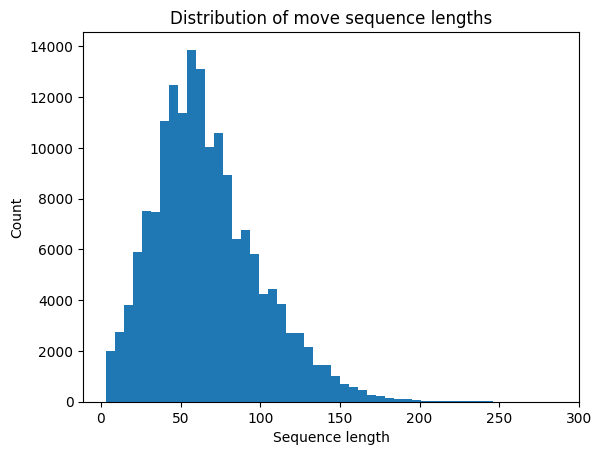

Sequence lenghts for some percentile values above the 90th:
90 113.0
95 129.0
97 140.0
99 160.0


In [20]:
lengths = train_df['tokenized_moves'].apply(len)

print('Move sequences lengths summary:')
print(lengths.describe())

plt.hist(lengths, bins=50)
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.title("Distribution of move sequence lengths")
plt.show()

print('Sequence lenghts for some percentile values above the 90th:')
for p in [90, 95, 97, 99]:
    print(p, np.percentile(lengths, p))

In [ ]:
max_len = 129 # 95th percentile
truncated = (lengths > max_len).mean()
print(f"Truncated sequences: {100 * truncated:.2f}%")

Truncated sequences: 4.87%


In [ ]:
train_moves = pad_sequences(train_df['tokenized_moves'].tolist(),
                             maxlen=max_len,
                             padding='post',
                             truncating='post')

val_df['tokenized_moves'] = val_df['clean_moves'].apply(tokenizer.encode)
val_moves = pad_sequences(val_df['tokenized_moves'].tolist(),
                             maxlen=max_len,
                             padding='post',
                             truncating='post')

test_df['tokenized_moves'] = test_df['clean_moves'].apply(tokenizer.encode)
test_moves = pad_sequences(test_df['tokenized_moves'].tolist(),
                             maxlen=max_len,
                             padding='post',
                             truncating='post')

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000

train_loader = create_dataset(train_moves, BATCH_SIZE, is_training=True)
val_loader   = create_dataset(val_moves, BATCH_SIZE, is_training=False)
test_loader  = create_dataset(test_moves, BATCH_SIZE, is_training=False)

# Exercise 1: KV Cache (mandatory)

**KV caching** is a mechanism implemented in autoregressive transformer models, wherein previous key and value computations are stored and reused when predicting a new token (see book, Chapter 11) and [this blog post](https://magazine.sebastianraschka.com/p/coding-the-kv-cache-in-llms).

> 🟨 Required reading before proceeding: [https://jax-ml.github.io/scaling-book/inference/](https://jax-ml.github.io/scaling-book/inference/).

**TODO**: Write and test a variant of multi-head attention with an internal KV cache mechanism. This is mostly didactical, so you should not concern too much with speed and efficiency (very difficult to achieve in practice).

💡 *Hint*: Start by coding the MHA layer and then add the KV Caching mechanism.

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. Importantly, describe carefully the design of the layer. Train a model with the new layer and show some plots to visualize the training (e.g., loss curves, perplexity, ...) on the data you loaded before.*

**TODO**: add description here (1-2 paragraphs).

## Multi-Head Attention

The `attention` function that computes dot-product attention scores using the Query $(Q)$, Key $(K)$ and Value $(V)$ projections of the layer's input:
$$
H = softmax\bigg(\frac{QK^T}{\sqrt{d}}\bigg)V
$$

This function was used to build a `MultiHeadAttention` (MHA) layer that takes as input:

- A key (for pseudorandom initialization management)
- The layer's input and output dimensions
- The number of heads $N_h$
- A binary `use_bias` variable, telling the model to initialize and use biases for the projection matrices $W_q$, $W_k$, $W_v$, and $W_o$
- A binary `causal` variable that applies causal masking to the attention function
- A final binary `cache` variable to initialize and use the KV Cache mechanism

Thus, the layer computes the dimension of each head as `in_dim//num_heads` and splits the input key in 4 subkeys, each used to initialize a projection matrix. The projection matrices $W_q$, $W_k$, $W_v$, and $W_o$ are initialized using the Xavier/Glorot Normal initialization (initial matrix values are sampled from a $\mathcal{N\bigg(0, \sqrt\frac{2}{in\_dim + out\_dim}\bigg)}$ distribution), if we selected to use biases, they're initialized as zero vectors of dimension equal to the number of rows of their respective projection matrix.

When an input tensor $x\in\mathbb{R}^{B\times L\times D}$ (with $B$ being the batch size, $L$ the sequence length and $D$ the embedding dimension) reaches the layer, it gets projected three times:
$$
Q = xW_q+b_q, \quad K = xW_k+b_k, \quad V = xW_V+b_v
$$
into the Query, Key and Value spaces of dimension $D$.

These projections are reshaped to $(B, L, N_h, d_h)$, (with $N_h$ and $h_d$ being the number of heads and their respective dimension) and then transposed to $(B, N_h, L, d_h)$, ensuring that the successive dot-product attention operates only on the last two dimensions, for each head independently.

The attention scores ($H_1, \ldots{}, H_H$) thus computed, either with or without causal masking (during inference, causal masking is unnecessary because the cache only contains keys from previous time steps), are then transposed to $(B, L, N_h, d_h)$ and concatenated back to $(B, L, D)$  before being projected to the layer's output dimension:
$$
H = [H_1, \ldots{}, H_H]W_o
$$


This layer contains two distinct methods: `__call__` is the layer's forward pass at training time, it processes the full sequence in parallel and, if enabled applies a causal mask; on the other hand, the `decode` method represents the process to compute the output of the layer at inference time: here a KV caching mechanism is provided to the layer, allowing it to attend over cached keys and values without needing an explicit mask, nor the recomputation of previous key-value pairs at each generation step.

## KV Cache

In classic autoregressive transformer inference the model generates a sequence one token at a time based on the inputs and on the previously generated tokens by estimating a probability distribution:
$$
p(x) = \prod_i p(x_i|\ x_{<i})
$$

where $p(x_i | \ x_{<i}) = Categorical(x_i|\ f_{\theta}(x_{<i}))$ is estimated through a function $f_{\theta}$ parametrized by a neural network.

Once a token is generated by sampling its value from the estimated probability distribution, its key-value pairs in MHA are used to generate the subsequent ones, and these values are recomputed at each generation step. This process is highly redundant and implies that generating a sequence of $n$ tokens has a cost of $O(n^2)$.
The KV Cache mechanism reduces this complexity to $O(n)$ by saving keys and values computed for previous tokens in a cache and reusing them during autoregressive generation.<sup><a href="footnote4">[4]</a></sup>

<a name="footnote4"></a>
[4] https://jax-ml.github.io/scaling-book/inference/

## Transformer Block

The Multi-Head Attention layer was used to build a *pre-normalized* transformer block in which it is preceded and followed by a Layer Normalization (LN) and a shallow MultiLayer Perceptron (MLP) composed of just two Linear layers interleaved with a GELU activation function.

The block also incorporates two residual connections: the first starts from the input of the block, while the second starts from the output of the first residual addition, ensuring that gradients can flow easily through both the attention and feed-forward sub-layers.

As in the MHA layer that composes it, the transformer block contains two different methods to compute its output, `__call__` is used at training time, while `decode` is used to compute the block's output during inference, leveraging a KV caching mechanism.

## Model Architecture

The model follows a *decoder-only* Transformer architecture. It begins with two Embedding layers (token and positional) that are followed by two transformer blocks, interleaved by a layer normalization, and followed by a two-layer MLP containing that uses a GELU activation and has the role to map the transformer's hidden state back to the vocabulary size to produce logits. Regularization is applied via Dropout ($p=30\%$) after each Transformer block and the first hidden layer of the final MLP.

## Model and Training Setup

The final model architecture has an embedding size of 128, both the MLP inside the transformer blocks and the linear layers of the model contain 256 neurons, and each MHA inside the transformer blocks has 4 heads. The sequence length is constrained to 129 tokens, corresponding to the 95th percentile of the sequence length distribution of the training set.

The model was trained for 50 epochs, with batches containing 128 sequences, using categorical cross entropy loss with the *AdamW* optimizer with a learning rate of $10^{-3}$, and a weight decay parameter $\lambda=10^{-4}$. Early stopping patience was set to 5 epochs, but was never triggered. The architectural and training configurations are summarized in [Table 1](#hyperparameter-table).

During training, the model is evaluated using perplexity and top-1 accuracy on training batches. These quantities, along with top-3 and top-5 accuracy are also computed on mini batches sampled from the validation set to monitor generalization capabilities.

<a id="hyperparameter-table"></a>
| Parameter | Value |
| :--- | :--- |
| Embedding Size | 128 |
| MLP Hidden Dimension | 256 |
| Attention Heads | 4 |
| Max Sequence Length | 129 |
| Batch Size | 128 |
| Epochs | 50 |
| Patience (Early Stopping)| 5|
| Learning Rate | $10^{-3}$ |
| Weight Decay ($\lambda$) | $10^{-4}$ |
| Dropout Probability ($p$) | 30% |

Table 1: *Model setup and training summary*

In [ ]:
key = jrand.PRNGKey(11)
model_key, train_key = jrand.split(key)

embedding_size = 128
mlp_size = 2*embedding_size
max_len = 129
vocab_size = len(tokenizer.vocab)
heads = 4

model = DecoderTransformer(model_key, vocab_size, max_len, heads, embedding_size, mlp_size)

In [ ]:
lr = 1e-3
batch_size = 128
epochs = 50
wd = 1e-4
patience = 5
optimizer = optax.adamw(lr, weight_decay=wd)
trained_model, training_history = train_model(model, train_loader, val_loader, train_key, patience, epochs)

Epoch 1/50 | Train Loss 4.9643 | Val Loss 4.3011 | Train Perplexity 193.199 | Val Perplexity 73.876 | Train top-1 Acc 0.121 |
Val top-1 Acc 0.177 | Val top-3 Acc 0.314 | Val top-5 Acc 0.386 | Best
Epoch 2/50 | Train Loss 4.3063 | Val Loss 4.0009 | Train Perplexity 74.459 | Val Perplexity 54.716 | Train top-1 Acc 0.172 |
Val top-1 Acc 0.203 | Val top-3 Acc 0.355 | Val top-5 Acc 0.434 | Best
Epoch 3/50 | Train Loss 4.1245 | Val Loss 3.8633 | Train Perplexity 61.948 | Val Perplexity 47.681 | Train top-1 Acc 0.187 |
Val top-1 Acc 0.216 | Val top-3 Acc 0.376 | Val top-5 Acc 0.457 | Best
Epoch 4/50 | Train Loss 4.0211 | Val Loss 3.7799 | Train Perplexity 55.836 | Val Perplexity 43.868 | Train top-1 Acc 0.196 |
Val top-1 Acc 0.223 | Val top-3 Acc 0.389 | Val top-5 Acc 0.472 | Best
Epoch 5/50 | Train Loss 3.9479 | Val Loss 3.7081 | Train Perplexity 51.889 | Val Perplexity 40.826 | Train top-1 Acc 0.202 |
Val top-1 Acc 0.230 | Val top-3 Acc 0.399 | Val top-5 Acc 0.483 | Best
Epoch 6/50 | Train 

In [ ]:
# Save the trained model to avoid recomputation
eqx.tree_serialise_leaves("model/trained_model.eqx", trained_model)

In [ ]:
# Save the training history
save_path = 'model/training_history.json'
with open(save_path, 'w') as f:
    json.dump(training_history, f)

# Verify the file exists
if os.path.exists(save_path):
    print(f"File successfully saved to: {save_path}")
    print(f"File size: {os.path.getsize(save_path)} bytes")
else:
    print("File was not saved.")

File successfully saved to: training_history3.json
File size: 8065 bytes


### Training Visualization

To assess if the model is correctly learning through the training process, train/validation loss and perplexity evolutions are plotted as epochs go by, training top-1 accuracy and validation top-1, 3 and 5 accuracies are displayed below as well.

The training process appears smooth and shows a steady decrease in training/validation loss and perplexity, coupled with a stable increase in accuracy. The model does not exhibit signs of overfitting: the validation loss and perplexity curves are always under their training counterparts, while validation accuracy remains higher than training accuracy.

While the training is stable, validation perplexity stabilizes near 25. While this is considerably smaller than a uniform distribution over the vocabulary (7826 tokens), it still highlights high uncertainty compared to an ideal perplexity of 1.<sup><a href="footnote5">[5]</a></sup>

The model achieves a modest top-1 accuracy (28.1%) on the validation set. However, top-5 accuracy reaches 57.7%, indicating that while the exact prediction is often incorrect, the true token is frequently within the model's top candidates. The decreasing trend exhibited by training and validation loss curves suggests that the model's performance was still improving at end of the training process and that increasing the number of training epochs would likely yield further gains in terms of performance.

Similar results are observed when testing the model on a final held out set, highlighting again the absence of symptoms of overfitting.

<a href="footnote5"></a>
[5] Aston Zhang et al. *Dive into Deep Learning*. 2023. arXiv: 2106 . 11342 [cs.LG]. url: https://arxiv.org/abs/2106.11342

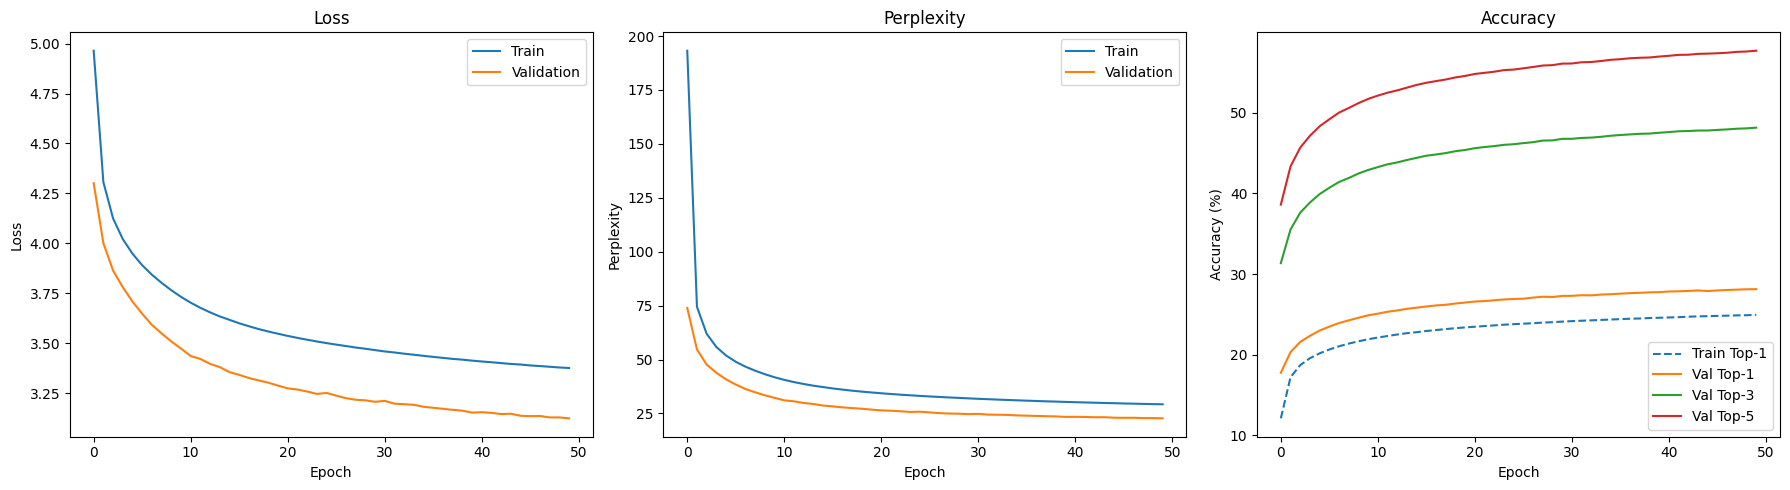

In [ ]:
# Load training history
with open('model/training_history.json', 'r') as f:
     training_history = json.load(f)

# Convert accuracies to percentage
acc_keys = ["train_top1", "val_top1", "val_top3", "val_top5"]
for k in acc_keys:
    training_history[k] = [v * 100 for v in training_history[k]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train and Validation Loss
axes[0].plot(training_history["train_loss"], label="Train")
axes[0].plot(training_history["val_loss"], label="Validation")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Train and Validation Perplexity
axes[1].plot(training_history["train_ppl"], label="Train")
axes[1].plot(training_history["val_ppl"], label="Validation")
axes[1].set_title("Perplexity")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Perplexity")
axes[1].legend()

# Accuracies
axes[2].plot(training_history["train_top1"], label="Train Top-1", linestyle="--")
axes[2].plot(training_history["val_top1"], label="Val Top-1", linestyle="-")
axes[2].plot(training_history["val_top3"], label="Val Top-3", linestyle="-")
axes[2].plot(training_history["val_top5"], label="Val Top-5", linestyle="-")
axes[2].set_title("Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy (%)")
axes[2].legend()

plt.tight_layout()
plt.show()

### Model Testing

In [ ]:
key = jrand.PRNGKey(11)
model_key, train_key = jrand.split(key)

embedding_size = 128
mlp_size = 2*embedding_size
max_len = 129
vocab_size = len(tokenizer.vocab)
heads = 4

model_eval = DecoderTransformer(model_key, vocab_size, max_len, heads, embedding_size, mlp_size)
# Load the trained model
model_eval = eqx.tree_deserialise_leaves("model/trained_model.eqx", model_eval)

In [ ]:
test_model(test_loader, model_eval)

Test Loss: 3.1240
Test Perplexity: 22.76
Test top-1 Accuracy: 28.16%
Test top-3 Accuracy: 48.17%
Test top-5 Accuracy: 57.70%


## KV Cache Performance Analysis

After training the model, its generative speed is evaluated on the test set, comparing scenarios in which a KV caching mechanism is used against *"vanilla"* generation.

The first plot below shows how the per-token latency evolves with respect to the token position, it displays that when the model doesn't use the KV cache, the latency increments with the token position, whereas using the caching mechanism the per-token latency is roughly constant as the length of the generated sequence increases. Analyzing the box plots representing the distributions of the times to generate the first token (TTFT), we can observe that both distributions show very small inter-quartile ranges and that, on average, the TTFTs when using the KV cache are slightly lower than the ones obtained without it. This graphic also shows that both distributions present some outliers, with an extreme value close to 0.8 seconds in the TTFT distribution obtained using the caching mechanism.

The third plot shows how the cumulative latency to generate tokens increases with the number of tokens. This underlines once again the effectiveness of the KV cache mechanism, since the curve associated with its generation latency is always below the one relative to obtained when recomputing previous key-value pairs at each time step, it also emphasizes that its efficiency gets more evident with the quantity of tokens generated since the divergence between the curves increases with the number of tokens generated. The last plot represents the distributions of the time needed to generate a single token and highlights once again that the cached generation has a lower latency with respect to the normal generation.

In [ ]:
key = jrand.PRNGKey(11)
model_key, train_key = jrand.split(key)

embedding_size = 128
mlp_size = 2*embedding_size
max_len = 129
vocab_size = len(tokenizer.vocab)
heads = 4

model_eval = DecoderTransformer(model_key, vocab_size, max_len, heads, embedding_size, mlp_size)
# Load the trained model
model_eval = eqx.tree_deserialise_leaves("model/trained_model.eqx", model_eval)

In [ ]:
# Set the model in inference mode and save generation speed results
model_eval = eqx.tree_inference(model_eval, value=True)
results = benchmark_model(model_eval, test_loader)

In [ ]:
# Create and save a DataFrame for TTFT with and without cache and for final cache lengths
res_df = pd.DataFrame({
    "ttft_no_cache": results["ttft_no_cache"],
    "ttft_cache": results["ttft_cache"],
    "final_cache_len": results["final_cache_len"]
})
res_df.to_csv('results/results_ttft_cache_len.csv', index=False)

# Save the per-token times with and without cache
pd.DataFrame(results["tok_time_no_cache"]).to_csv("results/nocache_per_token_time.csv")
pd.DataFrame(results["tok_time_cache"]).to_csv("results/cache_per_token_time.csv")

In [ ]:
# Save the result dictionary
with open('results/complete_results.json', "w") as f:
        json.dump(results, f, indent=4)

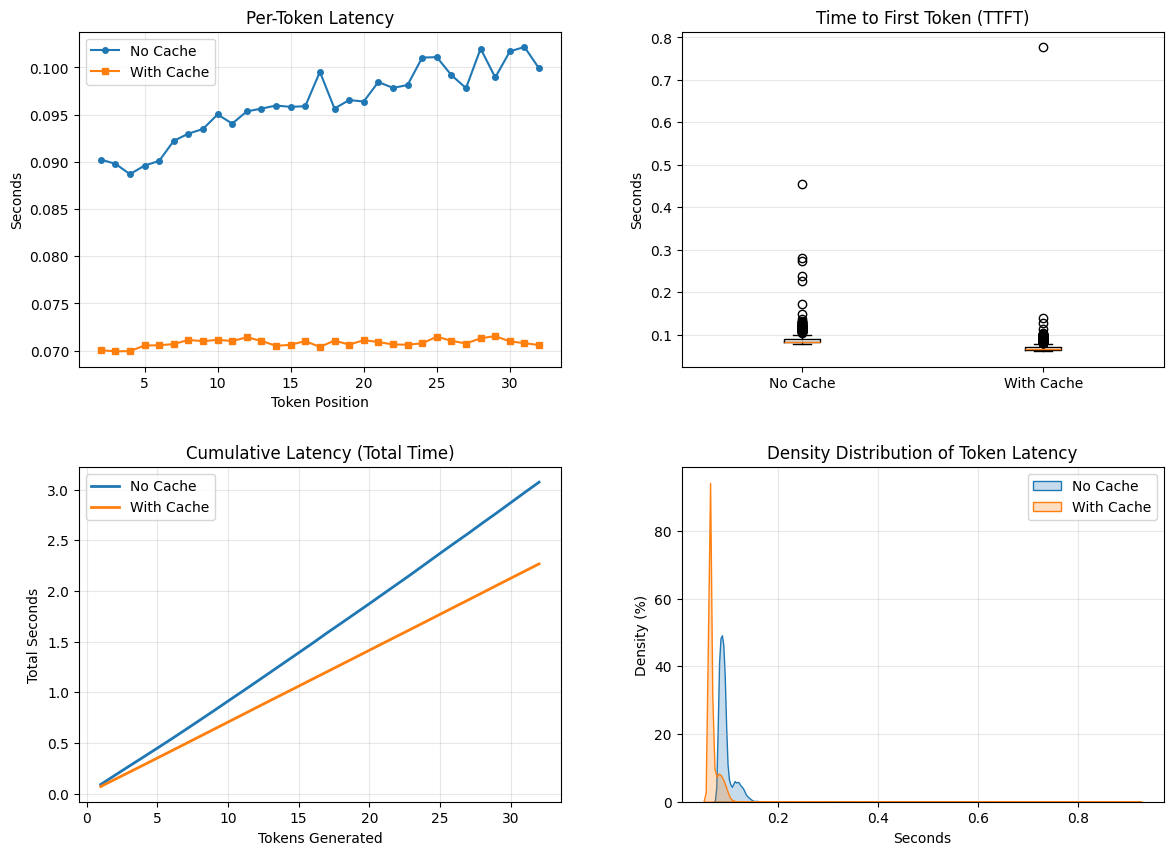

In [13]:
with open("results/complete_results.json", "r") as f:
    results = json.load(f)

ttft_no_cache = np.array(results["ttft_no_cache"])
ttft_cache = np.array(results["ttft_cache"])

max_new_tokens = 32

# Reshape per-token times: (num_samples, tokens_per_sample)
num_samples = len(ttft_no_cache)
tokens_per_sample = max_new_tokens - 1

pt_no_cache = np.array(results["tok_time_no_cache"]).reshape(num_samples, tokens_per_sample)
pt_cache = np.array(results["tok_time_cache"]).reshape(num_samples, tokens_per_sample)

token_indices = np.arange(2, max_new_tokens + 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Per-Token Latency vs Token Index
ax = axes[0, 0]
ax.plot(token_indices, pt_no_cache.mean(axis=0), label="No Cache", marker='o', markersize=4)
ax.plot(token_indices, pt_cache.mean(axis=0), label="With Cache", marker='s', markersize=4)
ax.set_title("Per-Token Latency")
ax.set_xlabel("Token Position")
ax.set_ylabel("Seconds")
ax.legend()
ax.grid(True, alpha=0.3)

# TTFT Box Plot
ax = axes[0, 1]
ax.boxplot([ttft_no_cache, ttft_cache], tick_labels=["No Cache", "With Cache"])
ax.set_title("Time to First Token (TTFT)")
ax.set_ylabel("Seconds")
ax.grid(True, axis='y', alpha=0.3)

# Cumulative Generation Latency
ax = axes[1, 0]
cumul_no_cache = np.cumsum(np.hstack([ttft_no_cache[:, None], pt_no_cache]), axis=1).mean(axis=0)
cumul_cache = np.cumsum(np.hstack([ttft_cache[:, None], pt_cache]), axis=1).mean(axis=0)
full_indices = np.arange(1, max_new_tokens + 1)

ax.plot(full_indices, cumul_no_cache, label="No Cache", linewidth=2)
ax.plot(full_indices, cumul_cache, label="With Cache", linewidth=2)
ax.set_title("Cumulative Latency (Total Time)")
ax.set_xlabel("Tokens Generated")
ax.set_ylabel("Total Seconds")
ax.legend()
ax.grid(True, alpha=0.3)

# Distribution of Per-Token Times
ax = axes[1, 1]

data_no_cache = pt_no_cache.flatten()
data_cache = pt_cache.flatten()

sns.kdeplot(
    data_no_cache, 
    fill=True, 
    label="No Cache", 
    ax=ax, 
    bw_adjust=0.5
)
sns.kdeplot(
    data_cache, 
    fill=True, 
    label="With Cache", 
    ax=ax, 
    bw_adjust=0.5
)

ax.set_title("Density Distribution of Token Latency")
ax.set_xlabel("Seconds")
ax.set_ylabel("Density (%)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

In [ ]:
summary("No Cache", ttft_no_cache)
summary("With Cache", ttft_cache)

# Calculate the difference/overhead
mean_diff = np.mean(ttft_cache) - np.mean(ttft_no_cache)
print(f"TTFT Overhead for Cache: {mean_diff:+.4f}s")

No Cache Time To First Token (TTFT) Summary
Mean:   0.0913 s
Median: 0.0834 s
Std:    0.0277 s
Min:    0.0778 s
Max:    0.4544 s
95th Percentile:    0.1211 s
99th Percentile:    0.2232 s

With Cache Time To First Token (TTFT) Summary
Mean:   0.0716 s
Median: 0.0652 s
Std:    0.0367 s
Min:    0.0606 s
Max:    0.7775 s
95th Percentile:    0.0932 s
99th Percentile:    0.1026 s

TTFT Overhead for Cache: -0.0197s


# Exercise 2: KV Cache compression (4 points)

**KV cache compression** algorithms try to dinamically reduce the size of the KV cache by, e.g., removing key/value pairs, or compressing them to a reduced set of tokens. See [this paper](https://arxiv.org/abs/2406.11430) for an introduction, and the [kvpress](https://github.com/NVIDIA/kvpress) library from NVIDIA for practical implementations (in PyTorch).

**TODO**: Reimplement (and test) one of the methods from the KVPress library (e.g., `KnormPress`).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code. When feasible, show some statistics on the layer (e.g. on the resulting size of the KV cache and/or which tokens tend to be selected for exclusion).*

**TODO**: add description here (1-2 paragraphs).

## $L_2$ Norm-based KV Cache Compression

$L_2$ norm-based KV cache compression method was implemented following the results obtained by Devoto et al.,<sup><a href="footnote6">[6]</a></sup> in which the authors show that $L_2$ norm of cached keys has a high correlation with attention scores and that low $L_2$ norm of a key embedding usually is associated with higher attention scores, proposing a method that keeps in memory only the keys associated with the lowest $L_2$ norms, together with their corresponding values.

To assess if the compression method works, a mini batch was extracted from the test set and was gave as input to the model with different maximum cache lengths (from 10 to 100 with steps of 10 tokens). The results of this experiment are shown in the first figure below: before the maximum cache length is reached the size of the KV cache increases linearly with the number of tokens processed. Once the cache length limit is exceeded, the compression method is triggered: keys with the larger $L_2$ norms are dropped (along with their values), resulting in the observed plateau in cache size. This behavior is consistent across all tested cache limits, confirming that the compression mechanism correctly constrains KV cache size during decoding. 

To perform a comprehensive evaluation, the model's performance was measured in terms of perplexity and top-1, 3, and 5 accuracy on 10 mini batches extracted from the test set (1280 evaluation units) for different maximum lengths. Perplexity steadily decreases as the allowed cache length increases, while accuracies improve analogously. As the cache length grows, performance approaches the one obtained without compression, indicating that longer KV caches, and thus broader contexts, are beneficial for model performance. It's worth noting that these results are obtained on a subset of the full test set (approximately 2.5%), and that more precise estimates could be obtained by testing the method on a larger sample. A smaller subset was used here to keep computations light while allowing evaluation across multiple cache limits.

<a name="footnote6"></a>
[6] Devoto, A., Zhao, Y., Scardapane, S., & Minervini, P. (2024). A Simple and Effective $L_2$ Norm-Based Strategy for KV Cache Compression. 4th NeurIPS Efficient Natural Language and Speech Processing Workshop (ENLSP-IV 2024), 18476–18499. https://doi.org/10.18653/v1/2024.emnlp-main.1027

In [ ]:
key = jrand.PRNGKey(11)
model_key, train_key = jrand.split(key)

embedding_size = 128
mlp_size = 2*embedding_size
max_len = 129
vocab_size = len(tokenizer.vocab)
heads = 4

model_eval = DecoderTransformer(model_key, vocab_size, max_len, heads, embedding_size, mlp_size)
# Load the trained model
model_eval = eqx.tree_deserialise_leaves("model/trained_model.eqx", model_eval)

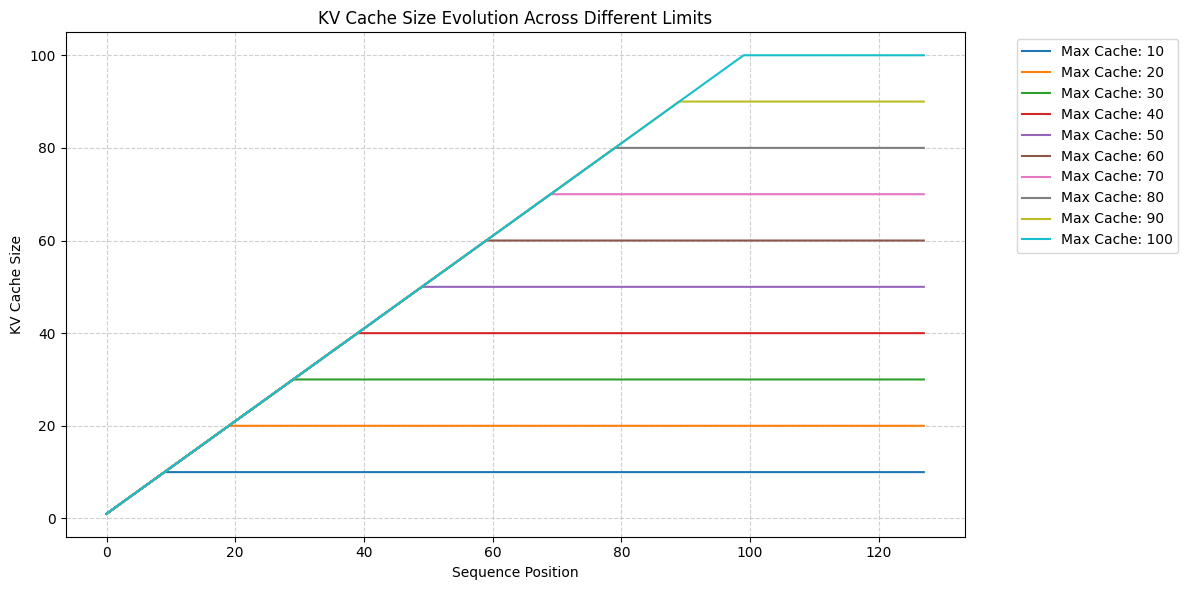

In [ ]:
# Limits to test
max_cache_limits = np.linspace(10, 100, 10, dtype=int)
# Extract one batch
num_samples = 128
test_batch_x, _ = next(iter(test_loader))
sequences = jnp.array(test_batch_x.numpy())[:num_samples]
seq_len = sequences.shape[1]

plt.figure(figsize=(12, 6))

for limit in max_cache_limits:
    # Initialize Model State with Cache
    current_model = model_eval.init_cache(num_samples)
    size_history = []

    for t in range(seq_len):
        x_t = sequences[:, t]

        # Forward pass
        current_model, logits = current_model.decode(x_t, t)

        # Access the cache an check current length
        k_layer1 = current_model.transf_block1.attn.cache.key
        current_len = k_layer1.shape[2]

        # Apply compression if cache exceeds the limit
        if current_len > limit:
            new_c1 = compress_cache(current_model.transf_block1.attn.cache, limit)
            new_c2 = compress_cache(current_model.transf_block2.attn.cache, limit)

            current_model = eqx.tree_at(
                lambda m: (m.transf_block1.attn.cache, m.transf_block2.attn.cache),
                current_model,
                (new_c1, new_c2)
            )

        size_history.append(current_model.transf_block1.attn.cache.key.shape[2])

    plt.plot(size_history, label=f"Max Cache: {limit}")

plt.xlabel("Sequence Position")
plt.ylabel("KV Cache Size")
plt.title("KV Cache Size Evolution Across Different Limits")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
cache_lengths = np.linspace(10, 100, 10, dtype=int)
sub_test_loader = test_loader.take(10)

In [45]:
metrics_compression = evaluate_metrics_compression(model_eval, sub_test_loader, cache_lengths)

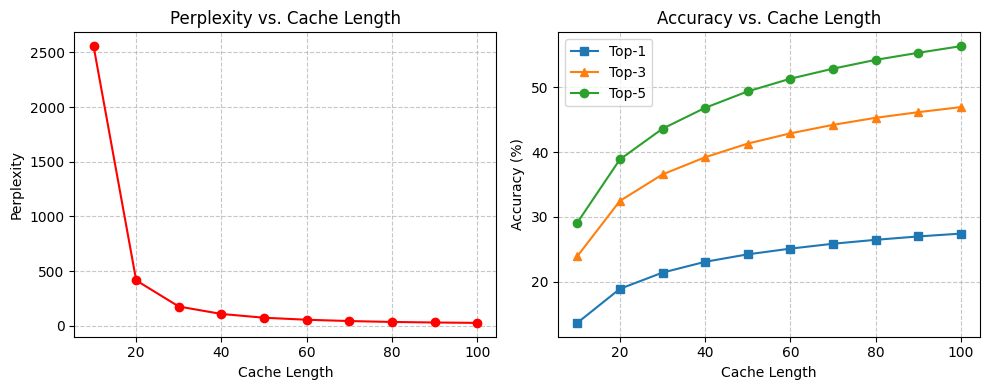

In [53]:
plt.figure(figsize=(10, 4))

cache_lengths = metrics_compression["cache_lengths"]

# Perplexity Plot
plt.subplot(1, 2, 1)
plt.plot(cache_lengths, metrics_compression["perplexity"], marker='o', linestyle='-', color='red')
plt.title('Perplexity vs. Cache Length')
plt.xlabel('Cache Length')
plt.ylabel('Perplexity')
plt.grid(True, linestyle='--', alpha=0.7)

# Accuracy Plot
plt.subplot(1, 2, 2)
# Convert to percentage
plt.plot(cache_lengths, [x * 100 for x in metrics_compression["top1"]], marker='s', label='Top-1')
plt.plot(cache_lengths, [x * 100 for x in metrics_compression["top3"]], marker='^', label='Top-3')
plt.plot(cache_lengths, [x * 100 for x in metrics_compression["top5"]], marker='o', label='Top-5')

plt.title('Accuracy vs. Cache Length')
plt.xlabel('Cache Length')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()